# Technical Report: Analysis of Instacart Orders Placed in Year 2017 

### Published By: Darshan Donthi

### Background:
Instacart is a company that operates a grocery delivery and pick-up service, and is headquartered in San Francisco.<br> 
This report uses an anonymized dataset which contains a sample of over 3 million grocery orders from more than 200,000 Instacart users in 2017 [1].

### Objectives: ###

**1) Answer two key business questions:**<br>
-- What products are reordered the most?<br>
-- What times of day are these products ordered?<br>

**2) Predict the hour of day a user will place an order:**<br>
-- Create Polynomial Regression models of varying degrees<br>
-- Use metrics to determine the best model and its viability<br> 

### Table of Contents:

**Section 1:** Read, Clean, and Explore the Data <br>
**Section 2:** Answering Key Business Questions <br>
**Section 3:** Feature Engineering for Use in Predictive Models <br> 
**Section 4:** Predictive Models and Analysis <br>
**Section 5:** Future Work<br>

### Data Dictionary [2]:
    
`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`departments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)

## Section 1: Read, Clean, and Explore the Data

### Read in All Data Sets

In [1]:
#Import necessary libraries for use.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Set index and rename columns for all DFs while reading them in.

#Read in aisles data.
aisles = pd.read_csv("./data/instacart_dataset_2017/aisles.csv", index_col='aisle_id'); #set index to aisle_id (Primary Key)
aisles.columns = ['aisle_name']; #rename column aisle to aisle_name

#Read in departments data.
departments = pd.read_csv("./data/instacart_dataset_2017/departments.csv");
departments.columns = ['dept_id','dept_name'];   #rename column names (for readability)
departments.set_index('dept_id', inplace = True);   #reset index of departments to dept_id (Primary Key)

#Read in products data.
products = pd.read_csv("./data/instacart_dataset_2017/products.csv");
products.rename(columns = {'department_id':'dept_id'}, inplace = True) #Rename department_id to dept_id (for readability)
products.set_index('product_id', inplace = True);   #reset index of products to product_id (Primary Key)

In [3]:
#Read in orders data (~3.4 m rows).
orders = pd.read_csv("./data/instacart_dataset_2017/orders.csv", index_col='order_id');
orders.sort_index(axis = 0, inplace = True); #sorts data according to row index order_id

#Read in order products data.
order_products_train = pd.read_csv("./data/instacart_dataset_2017/order_products__train.csv");  # ~131k orders

D:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Clean the Data

In [4]:
#Check fill rate of aisles DF.
print(aisles.notnull().mean())

#There are no missing aisle names.

aisle_name    1.0
dtype: float64


In [5]:
#Check fill rate of departments DF.
print(departments.notnull().mean())

#There are no missing dept names.

dept_name    1.0
dtype: float64


In [6]:
#Check fill rate of products DF.
print(products.notnull().mean())

#There are no missing values in all three columns.

product_name    1.0
aisle_id        1.0
dept_id         1.0
dtype: float64


In [7]:
#Verify if all product names are unique.

print(f'Number of rows in products DF: {products.shape[0]}')
print(f'Number of unique product names: {products.product_name.nunique()}')

#The number of product names matches the number of rows in products, so all product names are unique.

Number of rows in products DF: 49688
Number of unique product names: 49688


In [8]:
#Drop the "eval_set" column from orders DF.

orders.drop('eval_set', axis = 1, inplace = True)   #specify axis = 1 to drop a column

In [9]:
#Check fill rate of orders DF.

print(orders.notnull().mean())

user_id                   1.000000
order_number              1.000000
order_dow                 1.000000
order_hour_of_day         1.000000
days_since_prior_order    0.939724
dtype: float64


There are missing values in days_since_prior_order column. 
For this column, records with nulls are for new users to Instacart, so do not replace these values.

### Exploratory Data Analysis

In [10]:
#Number of unique users in orders DF.

print(f'Number of unique users in orders DF: {orders.user_id.nunique()}')

Number of unique users in orders DF: 206209


In [11]:
#Number of unique orders in order_products_train DF.

print(f'Number of unique orders in order_products_train DF: {order_products_train.order_id.nunique()}')

Number of unique orders in order_products_train DF: 131209


In [12]:
#Print the first few rows of orders DF.

display(orders.head(3))

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,
1,112108,4,4,10,9.0
2,202279,3,5,9,8.0
3,205970,16,5,17,12.0


In [13]:
#Print out sorted unique values of order_dow and order_hour_of_day from orders DF.

order_dow_unique = np.sort(orders.order_dow.unique())  #sorted NumPy array of unique order_dow values
order_dow_unique = list(order_dow_unique)  #convert np array to list   
order_hour_of_day_unique = np.sort(orders.order_hour_of_day.unique())  #sorted NumPy array of unique order_hour_of_day values.
order_hour_of_day_unique = list(order_hour_of_day_unique)  #convert np array to list

print(f'Order Days of Week: {order_dow_unique}')
print(f'Order Hours of Day: {order_hour_of_day_unique } ')

Order Days of Week: [0, 1, 2, 3, 4, 5, 6]
Order Hours of Day: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] 


### What day of the week is represented by Day 0?

**1) Plot histogram of number of orders per day to visualize distribution of data.**

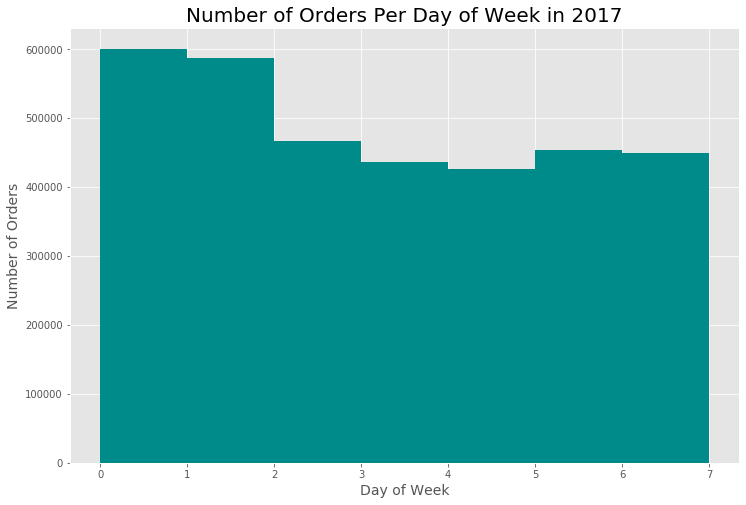

In [14]:
nbins = np.arange(0,8,1); #set bins so that each bin represents one day of the week
orders.hist(column = 'order_dow', figsize = (12,8), bins= nbins, color = 'darkcyan');
plt.title('Number of Orders Per Day of Week in 2017', fontsize = 20)
plt.xlabel('Day of Week', fontsize = 14);
plt.ylabel('Number of Orders', fontsize = 14);


**Analysis:**<br>

The order volume for Days 0 and 1 is significantly higher than each of Days 2 - 6.<br>
The order volume for Days 2 - 6 is relatively uniform (less variance in between days).<br>
Therefore, the distribution of daily order counts is right-skewed. Day 0 has the mode order volume, which is to the left of the day with mean order volume.<br>

My initial assumption is that Day 0 is Saturday, and Day 1 is Sunday.<br>
Perhaps users have more time to order groceries during the weekend than during weekdays because of employment.

**2) Plot and compare distributions of number of orders per hour on Days 6, 0, and 1.**

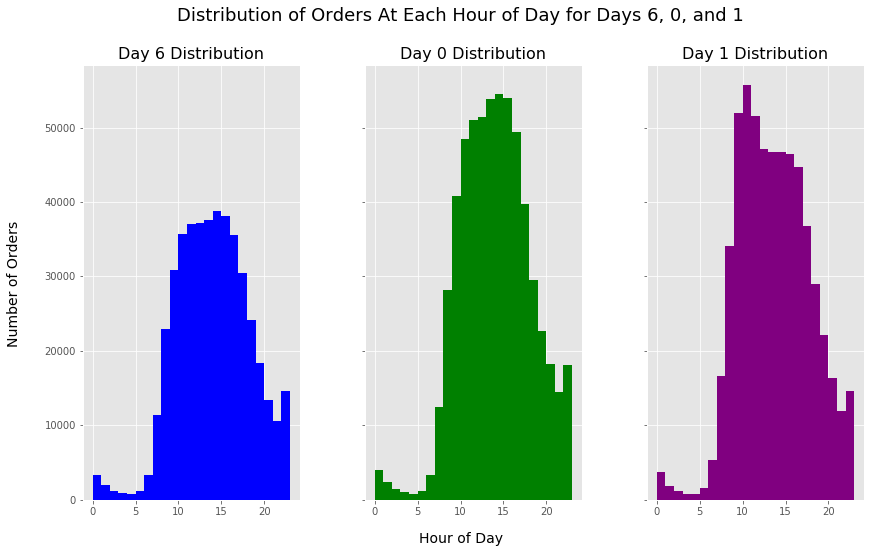

In [15]:
mask6 = (orders.order_dow == 6)  #create mask to save subset of orders placed on Day 6
orders_day_6 = orders[mask6]  #save subset of Day 6 orders

mask0 = (orders.order_dow == 0)  #create mask to save subset of orders placed on Day 0
orders_day_0 = orders[mask0]  #save subset of Day 0 orders

mask1 = (orders.order_dow == 1)  #create mask to save subset of orders placed on Day 1
orders_day_1 = orders[mask1]  #save subset of Day 1 orders

#Plot distribution of orders placed each hour of day on Days 6, 0, and 1.
fig, axes = plt.subplots(1, 3, figsize = (14,8),sharex = True, sharey = True);
plt.suptitle('Distribution of Orders At Each Hour of Day for Days 6, 0, and 1', fontsize = 18);

#Plot common xlabel and ylabel for all 3 subplots.
fig.text(0.5, 0.05, 'Hour of Day', ha='center', fontsize = 14);
fig.text(0.05, 0.5, 'Number of Orders', va = 'center', rotation = 'vertical', fontsize = 14);

nbins = np.arange(0,24,1); #set bins so that each bin represents one hour of the day

orders_day_6.hist(column = 'order_hour_of_day', color = 'blue', bins = nbins, ax = axes[0]);
axes[0].set_title('Day 6 Distribution', fontsize = 16);

orders_day_0.hist(column = 'order_hour_of_day', color = 'green', bins = nbins, ax = axes[1]);
axes[1].set_title('Day 0 Distribution', fontsize = 16);

orders_day_1.hist(column = 'order_hour_of_day', color = 'purple', bins = nbins, ax = axes[2]);
axes[2].set_title('Day 1 Distribution', fontsize = 16);


**Analysis:**

Days 6 and 0 have a maximum order volume around 3 PM. Day 1 has a maximum order volume around 11 AM. <br>
The distributions of Days 6 and 0 look very similar, however the Day 0 volume is scaled up significantly.<br>
The overall number of orders dramatically increases from Day 6 to Day 0, whereas Days 0 and 1 have a similarly large order volume.<br>
There is a big jump in order volume between hours 8 - 10 AM on Days 0 and 1 compared to Day 6.<br>

**Therefore, the insights obtained from this and the prior visualization lead me to assume that Day 0 is Saturday.**


### View relationships between variables

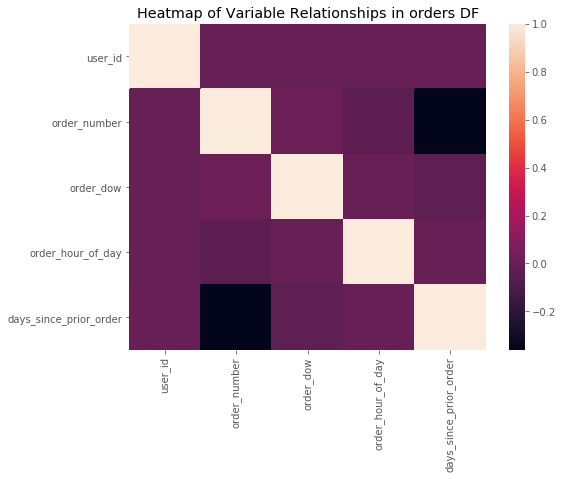

In [16]:
#Use a seaborn heatmap to view relationships between variables in orders DF.

plt.figure(figsize = (8,6));
plt.title('Heatmap of Variable Relationships in orders DF');
sns.heatmap(orders.corr()); #view pair-wise correlations between variables

**Variable Relationships:**<br>
There is a strong negative correlation between order_number and days_since_prior_order.<br>
There are no correlations between order_dow and any other variables.<br>
There are no correlations between order_hour_of_day and any other variables.<br>

## Section 2: Answering Key Business Questions

### What products are reordered the most?

In [17]:
#Merge order_products_train and products DFs to create ordersandproducts DF.

ordersandproducts = pd.merge(order_products_train, products, left_on='product_id', right_index = True)  #join on product_id
ordersandproducts.sort_values(['order_id','add_to_cart_order'], inplace = True) #sort DF by order_id and add_to_cart_order
display(ordersandproducts.head(3))   #print the first few rows of ordersandproducts DF

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,dept_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,Organic Celery Hearts,83,4


In [18]:
#Save all products which were reordered into the reordered_products DF.

mask = (ordersandproducts.reordered == 1)  #create filter to keep only products that were reordered
reordered_products = ordersandproducts[mask]  #save subset of products which were reordered
display(reordered_products.head(3))  #print the first few rows of the reordered_products DF

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,dept_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15


In [19]:
#Determine the number of times each reordered product was reordered by the same user.

reordered_product_counts = reordered_products.groupby('product_name').count()['product_id'] #counts per product_id

In [20]:
#Sort products by descending number of reorder counts.
sorted_reordered_product_counts = reordered_product_counts.sort_values(ascending=False)

#Print out the top-5 products.
print(sorted_reordered_product_counts.head())

product_name
Banana                    16557
Bag of Organic Bananas    13362
Organic Strawberries       8603
Organic Baby Spinach       8055
Organic Avocado            6226
Name: product_id, dtype: int64


**Plot horizontal bar graph of the top 20 products with the highest amount of reorders.**

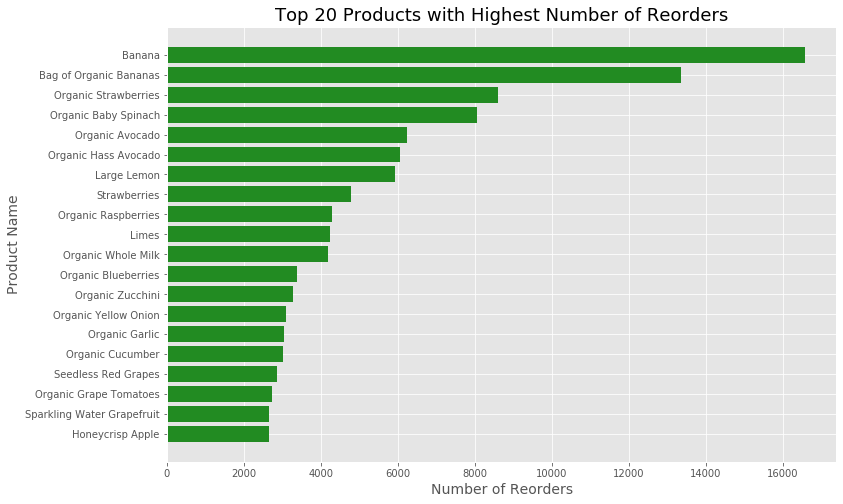

In [21]:
top20_reordered_product_counts = sorted_reordered_product_counts[:20]  #save top 20 products
top20_reordered_product_counts.sort_values(ascending = True, inplace = True) #order products ascending by reorder count

#Format and plot the horizontal bar graph.
plt.figure(figsize = (12,8));
plt.barh(top20_reordered_product_counts.index, top20_reordered_product_counts.values, color = 'forestgreen');
plt.title('Top 20 Products with Highest Number of Reorders', fontsize = 18);
plt.xlabel('Number of Reorders', fontsize = 14);
plt.ylabel('Product Name', fontsize = 14);


In [22]:
#Determine all departments the top 20 reordered products are located in.

#Merge top20_reordered_products_counts and products DFs.
top20_reordered_depts = pd.merge(top20_reordered_product_counts, products, left_index=True, right_on = 'product_name')

#Merge top20_reordered_depts and departments DFs.
top20_reordered_depts = pd.merge(top20_reordered_depts, departments, left_on = 'dept_id', right_index = True)

print(top20_reordered_depts.dept_name.value_counts())  #print out the number of top 20 products located in each relevant dept

produce       18
beverages      1
dairy eggs     1
Name: dept_name, dtype: int64


### What times of day are these products ordered?

In [23]:
#Create a new DF to save all order info for these top 20 products

top20_reordered_product_names = list(top20_reordered_product_counts.index)  #save product names

#subset of top-20 products based on product_name
top20_reordered_df = pd.DataFrame(columns = reordered_products.columns) #initialize empty DF with just column names

#iteratively concatenate product subsets to save all top 20 product orders info
for l in top20_reordered_product_names:
    #print(l)
    mask = (reordered_products['product_name'] == l)  #subset of orders for current product_name
    subset_df = reordered_products[mask]   #save subset of orders
    top20_reordered_df = pd.concat([top20_reordered_df, subset_df], axis = 0)  #concatenate current product orders subset

In [24]:
#Print out first few rows of top20_reordered_df.

display(top20_reordered_df.head(3))

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,dept_id
198,878,45066,4,1,Honeycrisp Apple,24,4
1359,3957,45066,7,1,Honeycrisp Apple,24,4
1477,4164,45066,23,1,Honeycrisp Apple,24,4


In [25]:
#Merge top20_reordered_df to orders DF on order_id (to access order_hour_of_day column).

top20_reordered_hour_df = pd.merge(top20_reordered_df, orders, left_on = 'order_id', right_index = True)

**Plot distributions of top 20 reordered product orders at each hour of day.**

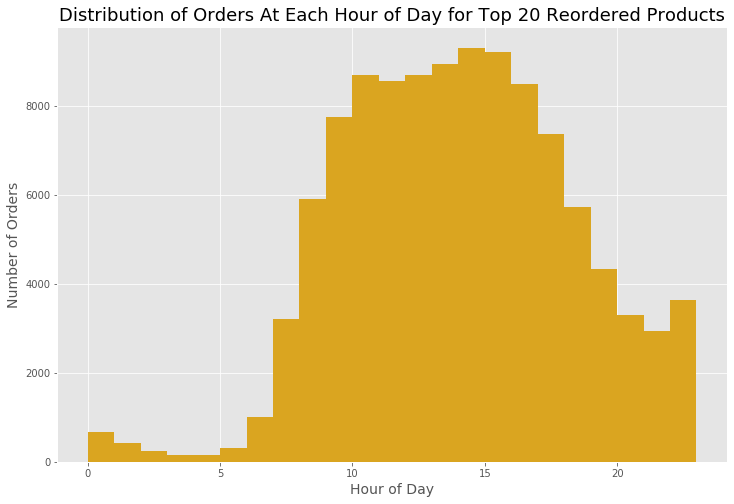

In [26]:
nbins = np.arange(0,24,1) #set bins so that each bin represents one hour of the day
top20_reordered_hour_df.hist('order_hour_of_day', bins = nbins, color = 'goldenrod', figsize = (12,8));
plt.title('Distribution of Orders At Each Hour of Day for Top 20 Reordered Products', fontsize = 18);
plt.xlabel('Hour of Day', fontsize = 14);
plt.ylabel('Number of Orders', fontsize = 14);


### Analysis and Suggestions ###

**What products are reordered the most?**<br>
The "produce" department contains 18 out of 20 of the top reordered products, with product "banana" topping the chart at 16,557 reorders in the year 2017 for this subset of Instacart users. The 2nd-most reordered product is "Bag of Organic bananas", which shows that any product involving a banana is most popular across all users. It is also worth noting that 13 out of 20 of the top reordered products contain the keyword "Organic", which suggests that Instacart users tend to be more health-conscious.

**What times of day are these products ordered?**<br>
The distribution of top 20 product orders at each hour is left-skewed, with the mode volume of orders around 2 pm. 
The volume of orders is pretty consistent from 10 AM to 5 PM, with approximately 9k orders placed per each of these hours in 2017. Since these products are consistently ordered at high volume throughout the day, these are the most popular and have the potential to bring in the most profits for grocery stores and Instacart alike.

**Suggestions for Stakeholders:** <br>
1) Grocery outlet: Be sure to regularly restock the produce department and look into organic produce options as well. Items from the produce department are the most popular, and can help boost sales when paired with products from under-performing departments. For instance, this could be achieved by having a weekly promotion pairing a banana with an item from another department at a slightly lower bundle price so users are more likely to purchase both products. <br>

2) Instacart: Try to actively suggest a top 20 product to be added to the cart for new Instacart users in order to establish product interest early. Also do this for repeat users by suggesting online bundle pricing deals with top 20 products at peak order hours of day prior to that user finalizing their cart and checking out. This will help promote users to buy products during surge pricing hours [3], and therefore bring in more profit to Instacart.  

3) Users: Items from the produce department will be available for purchase most hours of the day, so there is no need to worry about planning to order groceries at a particular time. Also, it might be wise to order produce at non-peak hours (prior to 10 am, and after 5 pm) so the delivery time for your order is faster, and thus fresher to eat.

## Section 3: Feature Engineering for Use in Predictive Models

In [27]:
#Merge orders and order_products_train DFs (to count number of products per order).
allordersandproducts = pd.merge(orders, order_products_train, left_index = True, right_on = 'order_id')

#Merge allordersandproducts and products DFs to get product names (join on product_id).
allordersandproducts = pd.merge(allordersandproducts, products, left_on = 'product_id', right_index = True)

display(allordersandproducts.head(3))  #print first few rows of DF

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,dept_id
0,112108,4,4,10,9.0,1,49302,1,1,Bulgarian Yogurt,120,16
335058,47901,14,4,6,16.0,816049,49302,7,1,Bulgarian Yogurt,120,16
505664,2993,15,0,7,7.0,1242203,49302,1,1,Bulgarian Yogurt,120,16


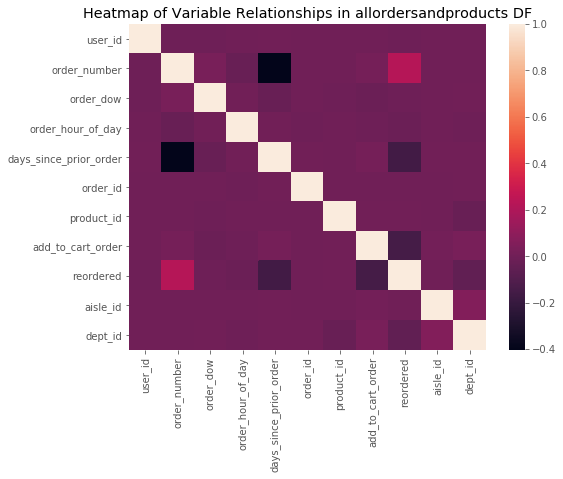

In [28]:
#Use seaborn heatmap to view relationships between all variables in allordersandproducts DF.

plt.figure(figsize = (8,6));
plt.title('Heatmap of Variable Relationships in allordersandproducts DF');
sns.heatmap(allordersandproducts.corr());  #view pair-wise correlations between variables

**Variable Relationships**:<br>
There is a positive correlation between order_number and reordered.<br>
There is a strong negative correlation between order_number and days_since_prior_order.<br>
There is a negative correlation between days_since_prior_order and reordered.<br>
There is a negative correlation between add_to_cart_order and reordered.<br>

### Engineered feature 1: cart_size

In [29]:
#Find total product count per order_id, and save as new column 'cart_size' in orders_engineered DF.

#Save total product count per order_id.
totalprodcount_perorder = allordersandproducts.groupby('order_id').count()['product_name']

#Create orders_engineered DF by merging orders DF and totalprodcount_perorder Series.
orders_engineered = pd.merge(orders, totalprodcount_perorder, left_on = 'order_id', right_index=True)

#Rename column 'product_name' to 'cart_size'.
orders_engineered.rename(columns = {'product_name':'cart_size'}, inplace = True)

In [30]:
#Print out the first few rows of orders_engineered DF to view new cart_size column.

display(orders_engineered.head(3))

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart_size
order_id,,,,,,
1,112108,4,4,10,9.0,8
36,79431,23,6,18,30.0,8
38,42756,6,6,16,24.0,9


### Engineered feature 2: num_top20_reordered_products

In [31]:
#Find the total count of top 20 reordered products in the cart for each order.

#Save all order_ids into a list and sort in ascending order.
all_order_ids = list(allordersandproducts.order_id.unique())  #save all unique order_ids into a list
all_order_ids.sort() #sort the list in-place

In [32]:
#For each order id, count the number of top 20 products in the cart.

num_top20_products_dict = dict(); #initialize dictionary where key is order_id and value is number of top 20 products in cart

#Iterate through all order_ids and save the count of number of top 20 products per order.
for oid in all_order_ids:
    mask = (allordersandproducts['order_id'] == oid)  #filter to save all products per order
    sub_df = allordersandproducts[mask]  #save all products per order into sub_df. resets for each order_id
    
    counter = 0  #counts number of top 20 products in cart. resets for each order_id
    
    for p in sub_df['product_name']:  #iterate through each product in cart
        if p in top20_reordered_product_names:  #checks if product_name is in the top20_reordered_product_names list
            counter+=1   #increment counter if product_name is in the top20_reordered_product_names list
         
    num_top20_products_dict[oid] = counter  #saves new dictionary entry with order_id as key, and counter as value

In [33]:
#Convert num_top20_products_dict into a DF.
num_top20_products_df = pd.DataFrame.from_dict(num_top20_products_dict, orient='index') #set key as row index of DF

#Rename new column to 'num_top20_reordered_products'.
num_top20_products_df.rename(columns = {0:'num_top20_reordered_products'}, inplace = True) 

display(num_top20_products_df.head(3))  #print first few rows of the DF

,num_top20_reordered_products
1,2
36,0
38,0


In [34]:
#Merge orders_engineered DF and num_top20_products_df on order_id.
orders_engineered = pd.merge(orders_engineered, num_top20_products_df, left_on = 'order_id', right_index=True)

display(orders_engineered.head(3))   #print first few rows of the DF

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart_size,num_top20_reordered_products
order_id,,,,,,,
1,112108,4,4,10,9.0,8,2
36,79431,23,6,18,30.0,8,0
38,42756,6,6,16,24.0,9,0


### Engineered feature 3: num_distinct_depts

In [35]:
#Find distinct number of departments represented by products in each order.

#Merge ordersandproducts with departments table to get dept names (join on dept_id)
allordersandproducts_depts = pd.merge(allordersandproducts, departments, left_on = 'dept_id', right_index = True)

display(allordersandproducts_depts.head(3))  #print first few rows of the DF

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,dept_id,dept_name
0,112108,4,4,10,9.0,1,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs
335058,47901,14,4,6,16.0,816049,49302,7,1,Bulgarian Yogurt,120,16,dairy eggs
505664,2993,15,0,7,7.0,1242203,49302,1,1,Bulgarian Yogurt,120,16,dairy eggs


In [36]:
#Find count of distinct departments per order.

#Group allordersandproducts_depts by both order_id and dept_name to create a multi-index.
prodcount_perorderanddept = allordersandproducts_depts.groupby(['order_id','dept_name']).count()['product_name']

In [37]:
#Group on multi-index level 'order_id' in order to count distinct number of depts represented by products in cart.

distinctdeptcount_perorder = prodcount_perorderanddept.groupby(level='order_id').count()
display(distinctdeptcount_perorder.head(3))  #print first few rows of the Series

order_id
1     3
36    4
38    4
Name: product_name, dtype: int64

In [38]:
#Add new column to orders_engineered DF, and rename it to 'num_distinct_depts'.

orders_engineered = pd.merge(orders_engineered, distinctdeptcount_perorder, left_on = 'order_id', right_index=True)
orders_engineered.rename(columns = {'product_name':'num_distinct_depts'}, inplace = True)
display(orders_engineered.head(3))  #print first few rows of the DF

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,cart_size,num_top20_reordered_products,num_distinct_depts
order_id,,,,,,,,
1,112108,4,4,10,9.0,8,2,3
36,79431,23,6,18,30.0,8,0,4
38,42756,6,6,16,24.0,9,0,4


### Check orders_engineered DF for any outliers

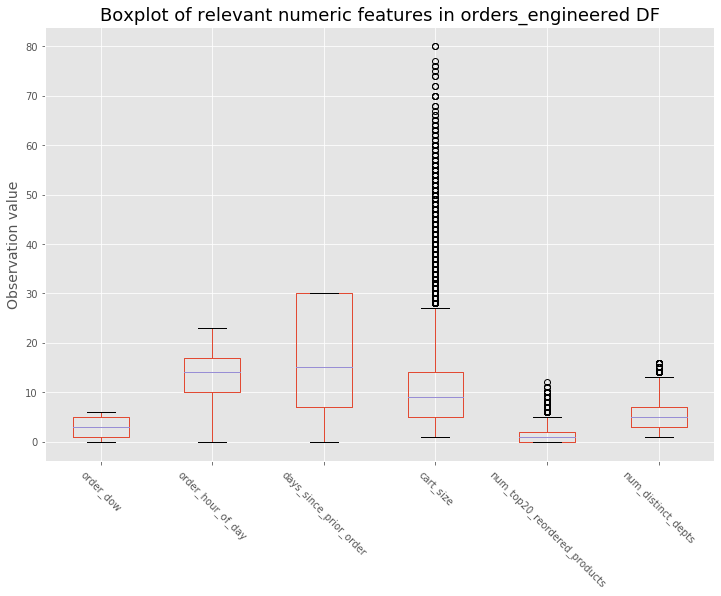

In [39]:
#Plot boxplots of relevant numeric features in orders_engineered DF.

orders_engineered.drop(columns = ['user_id', 'order_number']).boxplot(figsize = (12,8), rot = -45);
plt.title('Boxplot of relevant numeric features in orders_engineered DF', fontsize = 18);
plt.ylabel('Observation value', fontsize = 14);

The column cart_size has many high-value outliers ranging between values of approximately 30 to 80.<br>
These outliers need to be removed prior to creating and training models.

**Find and remove outliers in cart_size column by calculating Z-scores of each value.**<br>
Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured. An outlier is a value which has a Z-score greater than 3.

In [40]:
from scipy import stats  #import stats library

cartsize_df = orders_engineered[['cart_size']]  #isolate cart_size column into a new DF
cartsize_df.sort_values('cart_size', ascending = True, inplace = True)  #sorted values by cart_size
display(cartsize_df.head(3))  #print first few rows of the DF

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,cart_size
order_id,
2695197,1
2724381,1
129983,1


In [41]:
#Calculate Z-score of each cart_size value.

z = np.abs(stats.zscore(cartsize_df))  #calculate z-score of each value

threshold = 3  #number of standard deviations from the mean value

cartsize_outliers = np.where(z > 3) #save all values greater than 3 standard deviations away from mean (outliers)

In [42]:
#Print the number of outliers and percentage of outliers in cart_size.

outlier_count = (len(z[cartsize_outliers]))  #use filter to save count of outliers
print(f'Number of outliers in cart_size: {outlier_count}')

percent_outliers = (100 * (len(z[cartsize_outliers])) / (orders_engineered.shape[0]) )  #outlier count / total count of values
print(f'Percentage of outliers in cart_size: {percent_outliers:.2f}')

Number of outliers in cart_size: 1846
Percentage of outliers in cart_size: 1.41


In [43]:
#Save all rows of orders_engineered with cart_size values that are not outliers into a new clean DF.

cartsize_df_clean = cartsize_df[(z < 3).all(axis=1)]  #save all clean cart_size data

In [44]:
#Create new DF with only non-outlier cart_size data (clean data).

cartsize_df_clean_oids =  list(cartsize_df_clean.index) #save all clean order_ids into a list

orders_eng_clean = orders_engineered.loc[cartsize_df_clean_oids[:]]  #save all rows with clean order_ids (index)

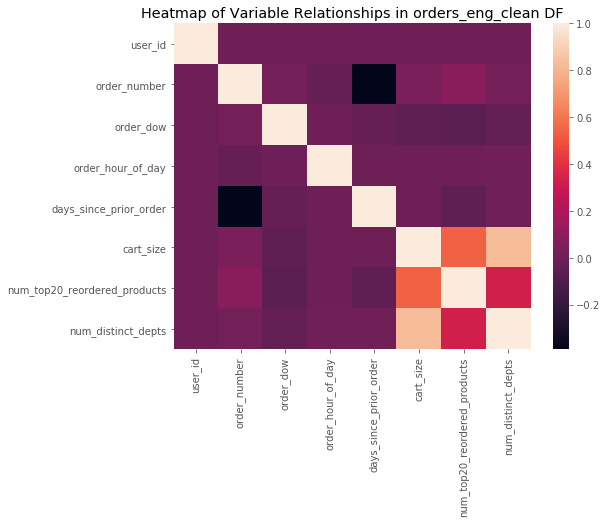

In [45]:
#Plot relationships between variables in orders_eng_clean DF.

plt.figure(figsize = (8,6));
plt.title('Heatmap of Variable Relationships in orders_eng_clean DF');
sns.heatmap(orders_eng_clean.corr());  #view pair-wise correlations between variables

**Variable Relationships:**<br>
There is a positive correlation between cart_size and num_top20_reordered_products.<br>
There is a strong positive correlation between cart_size and num_distinct_depts.<br>
There is a strong negative correlation between days_since_prior_order and order_number.<br>
However there are no variables that are directly correlated with order_hour_of_day.

## Section 4: Predict the hour of day a user will place an order 

### Predict order_hour_of_day using a combination of original and engineered features.

In [46]:
#Import relevant modules.

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Create a Baseline Model and determine its Mean Squared Error (MSE).

In [47]:
#Use the mean of target variable "order_hour_of_day" from orders_eng_clean DF for all predictions.
#This baseline model requires 0 features to be trained upon.

#Save target vector y.
y = orders_eng_clean['order_hour_of_day']  

#Save prediction value as the mean of the y vector.
y_pred = y.mean()
print(f'Mean of order_hour_of_day (used for all predictions): {y_pred}')

#Find MSE between actual values and mean value.
mse = np.mean(np.square(y-y_pred))
print(f'Baseline MSE: {mse}')

Mean of order_hour_of_day (used for all predictions): 13.582894645300433
Baseline MSE: 17.80512070121141


### Create multiple Polynomial Regression Models and determine which model has the lowest MSE.

In [48]:
#Import library for use with Polynomial Regression.

from sklearn.preprocessing import PolynomialFeatures

In [49]:
#Create a list of highly-correlated features from orders_eng_clean DF.
feature_cols = ['order_number',
                'days_since_prior_order',
                'cart_size',
                'num_distinct_depts']

# Create X (predictor matrix) and y (target vector).
X = orders_eng_clean[feature_cols]
y = orders_eng_clean['order_hour_of_day']

#Create train/test split. 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42) #70/30 train/test split

In [50]:
#Iterate through k-degree polynomials and determine which k leads to the lowest MSE value.

mse_list = list(); #initialize scores list to save all testing errors (MSE) for desired range of k's

#Iterate through k's 1 to 10, fit the K-Polynomial Linear Regression Models, and save all MSE values. 
for k in range(1,11,1):
    #Instantiate a PolynomialFeatures object.
    poly = PolynomialFeatures(degree = k)  #generates all polynomial combinations of features less than or equal to degree k

    #Use fit_transform on X to create a numpy array of polynomial features.
    poly_feats_train = poly.fit_transform(X_train)  #fits and transforms the train set
    poly_feats_test = poly.fit_transform(X_test)  #fits and transforms the test set

    #Convert this array to a DataFrame and save it as poly_df.
    poly_df_train = pd.DataFrame(poly_feats_train)
    poly_df_test = pd.DataFrame(poly_feats_test)

    #Instantiate and fit model. Train the model on the training set.
    lr_p = LinearRegression()
    lr_p.fit(poly_feats_train, y_train)  #fit on polynomial features (transformed from X_train)

    #Predict order_hour_of_day using transformed testing set.
    poly_pred = lr_p.predict(poly_df_test) 

    #Calculate testing error (MSE).
    mse = metrics.mean_squared_error(y_test, poly_pred)  
    mse_list.append([k, mse]) #append both current k and MSE as a sub-list

In [51]:
#View k's and corresponding MSE values for k's 1 to 10.

mse_df = pd.DataFrame(mse_list,columns=['k','mse_value'])  #convert mse_list to DF

display(mse_df)

,k,mse_value
0,1,17.733797
1,2,17.714342
2,3,17.695641
3,4,17.700164
4,5,17.701941
5,6,17.722147
6,7,17.825310
7,8,18.064848
8,9,21.160661
9,10,24.459326


**Plot k's versus Mean Squared Error (MSE) to view how the MSE changes.**

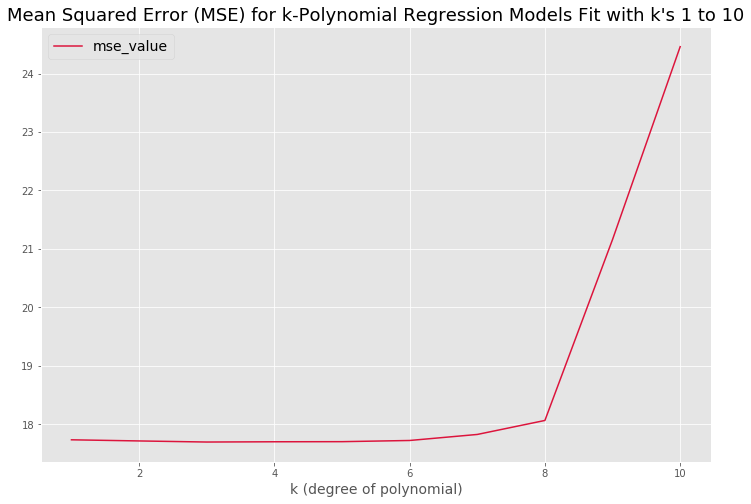

In [52]:
mse_df.plot(x='k',y='mse_value', figsize = (12,8), color = 'crimson');
plt.title("Mean Squared Error (MSE) for k-Polynomial Regression Models Fit with k's 1 to 10", fontsize = 18);
plt.xlabel('k (degree of polynomial)', fontsize = 14);
plt.legend(fontsize =14);


**Determine the k-Polynomial Regression model with the lowest MSE.**

In [53]:
minimum = mse_list[0]  #initialize variable to save [k, MSE] sublist with minimum score

for sub in mse_list:  #iterate through all sublists in mse_list
    if sub[1] < minimum[1]:  #compares MSE of current sublist to that of existing minimum sublist
        minimum = sub   #if current sublist has lower MSE, save it as a new minimum sublist

print(f'k-Polynomial with k as {minimum[0]} has the lowest MSE of {minimum[1]:.8f}.')


k-Polynomial with k as 3 has the lowest MSE of 17.69564142.


### Predictive Modeling Analysis: ###

The positive implications of having a working model to predict the order hour of day would be to bring in more profit to Instacart. Using the features of my current model, Instacart would ideally be able to test different groupings of products from multiple departments as well as varying cart sizes to narrow down the expected order hour of the user. In this way Instacart could actively recommend particular items at certain hours of day so that users are more likely to add these items to their cart. Since Instacart relies on surge pricing to bring in a portion of their profits [3], a larger cart size would allow them to capitalize upon the insights produced by this model.

I decided to use four features (independent variables) to train the polynomial regression models: 'order_number', 'days_since_prior_order', 'cart_size', and 'num_distinct_depts'. These seem to be the most logical to use to predict order_hour_of_day (target variable) because they have pair-wise correlations with each other as seen in the heatmap of orders_eng_clean DF earlier. There is a strong positive correlation between cart_size and num_distinct_depts, and there is a strong negative correlation between days_since_prior_order and order_number. I did not train the models using engineered feature 'num_top20_reordered_products' because it has the lowest pair-wise correlation to either of the two other engineered features.

The Degree-3 model has the lowest MSE out of the Degree-k polynomial regressions of k's 1 to 10. The Degree-3 model has a decrease of 0.11 MSE (improvement of 0.6%) compared to the Baseline model, for which all predictions are the mean of order_hour_of_day. This is an insignificant improvement from simply guessing the mean, and performance can be further impacted based on the train test split of the data (in this case I used a 70/30 train test split). In the case I used a lower proportion of data to train the model, the MSE potentially would have been higher (worse) than even the Baseline model.

**Conclusion: This Degree-3 polynomial regression model should not be used for predicting the order hour of day for a given user.**

## Section 5: Future Work

The dataset used in this report has limited predictive capability for order hour of day because it does not account for seasonality in online grocery shopping. The only other features establishing a sense of timeline in the data are the day_of_week and order_number columns, which have essentially no correlation to the order_hour_of_day column. 

The full dataset represents orders over the entire year of 2017, so engineering features from the existing dataset with higher-correlation to order_hour_of_day could lead to a better model. For instance, I could map ranges of hours to intervals of day (e.g. morning, afternoon, evening) and use a KNearestNeighbors Classifier Model to predict a particular day interval (less granular than order hour of day). Another option could be to find a supplemental dataset with more time-oriented features so I could conduct deeper analyses into seasonality of orders (e.g. timestamp of order, month of order, etc) and create a better model.

## References:

1) "3 Million Instacart Orders, Open Sourced", Accessed from https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2.

2) "The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <6/16/20>.

3) "How does Instacart make money?", Accessed from https://vator.tv/news/2016-08-02-how-does-instacart-make-money.